# Multicollinearity

"*When independent variables are highly correlated.*"

**Cool References to Check Out**

* https://www.investopedia.com/terms/m/multicollinearity.asp
* https://www.tandfonline.com/doi/pdf/10.1080/09720502.2010.10700699
* https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html


In [1]:
import pandas as pd

df = pd.read_csv('breastcancer.csv')
df.dropna(inplace=True) # vif can't be calculated with nan values!
df = df._get_numeric_data() # drop non-numeric cols aka categorical vars
df.head()

,radius,texture,perimeter,area,smoothness,compactness,concavity,symmetry,fractal_dimension,age,diagnosis
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.08690,0.1812,0.05667,27,1
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.19740,0.2069,0.05999,31,1
4,20.29,14.34,135.1,1297.0,0.10030,0.13280,0.19800,0.1809,0.05883,20,1
6,18.25,19.98,119.6,1040.0,0.09463,0.10900,0.11270,0.1794,0.05742,38,1
10,16.02,23.24,102.7,797.8,0.08206,0.06669,0.03299,0.1528,0.05697,51,1


In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Indicate which variables to compute VIF
X = df[['radius','texture','perimeter', 'area', 'smoothness', 'compactness',
        'concavity', 'symmetry', 'fractal_dimension', 'age']]

# add intercept
X['intercept'] = 1

# Compute VIF
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif

,variables,VIF
0,radius,2691.890851
1,texture,1.190516
2,perimeter,3398.214223
3,area,69.009830
4,smoothness,2.255147
5,compactness,21.960456
6,concavity,12.263368
7,symmetry,1.495297
8,fractal_dimension,4.235412
9,age,1.021168


From statsmodels:

>"**If VIF > 5**, then the explanatory variable is **highly collinear with the other explanatory variables**, and the parameter estimates will have **large standard errors** because of this."

It seems that **radius, perimeter, area, compactness, and concavity are above the threshold (VIF > 5)**. This means we should **drop these columns** as they will cause a negative effect on our logistic regression model.

From Investopedia:

>"It is **better to use independent variables that are not correlated** when building multiple regression models that use two or more variables."

In [3]:
df.drop(columns=['radius', 'perimeter', 'area', 'compactness','concavity'], inplace=True)
df.head()

,texture,smoothness,symmetry,fractal_dimension,age,diagnosis
1,17.77,0.08474,0.1812,0.05667,27,1
2,21.25,0.10960,0.2069,0.05999,31,1
4,14.34,0.10030,0.1809,0.05883,20,1
6,19.98,0.09463,0.1794,0.05742,38,1
10,23.24,0.08206,0.1528,0.05697,51,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 1 to 568
Data columns (total 6 columns):
texture              498 non-null float64
smoothness           498 non-null float64
symmetry             498 non-null float64
fractal_dimension    498 non-null float64
age                  498 non-null int64
diagnosis            498 non-null int64
dtypes: float64(4), int64(2)
memory usage: 27.2 KB


In [7]:
df.describe()

,texture,smoothness,symmetry,fractal_dimension,age,diagnosis
count,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
mean,19.286406,0.094303,0.177280,0.060837,39.246988,0.357430
std,4.303475,0.012568,0.024565,0.004563,13.584124,0.479725
min,9.710000,0.052630,0.106000,0.049960,16.000000,0.000000
25%,16.180000,0.085087,0.160100,0.057113,27.000000,0.000000
50%,18.830000,0.094240,0.176900,0.060815,40.000000,0.000000
75%,21.660000,0.102975,0.192600,0.064120,52.000000,1.000000
max,39.280000,0.144700,0.274300,0.070650,62.000000,1.000000


We already dropped null values, but you can verify this visually by applying a heat map.

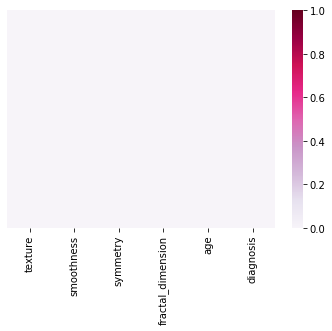

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# simple heat map showing where we are missing data
heat_map = sns.heatmap(df.isnull(), yticklabels = False, cbar = True, cmap = "PuRd", vmin = 0, vmax = 1)

plt.show()

So far, we have...

* Dropped categorical variables (id and name)
* Identified highly correlated predictor variables via VIF and dropped when VIF > 5
* Checked to see if we still have any nulls

We can go on to build our logistic regression model!

# Build the Model

#### Step 1: Split data into X and y

In [8]:
X = df.drop('diagnosis', axis = 1)
y = df['diagnosis']

In [9]:
X.head()

,texture,smoothness,symmetry,fractal_dimension,age
1,17.77,0.08474,0.1812,0.05667,27
2,21.25,0.10960,0.2069,0.05999,31
4,14.34,0.10030,0.1809,0.05883,20
6,19.98,0.09463,0.1794,0.05742,38
10,23.24,0.08206,0.1528,0.05697,51


In [10]:
y.head()

1     1
2     1
4     1
6     1
10    1
Name: diagnosis, dtype: int64

#### Step 2: Split data into train set and test set

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

#### Step 3: Train and predict

In [12]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\Morgan Kaiser\Anaconda3\Anaconda\New folder\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
y_predictions = logreg.predict(X_test)
y_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0], dtype=int64)

# Evaluate the Model

#### Classification Report

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.68      0.85      0.75        91
           1       0.62      0.39      0.48        59

    accuracy                           0.67       150
   macro avg       0.65      0.62      0.62       150
weighted avg       0.66      0.67      0.65       150



#### Confusion Matrix

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_predictions)

array([[77, 14],
       [36, 23]], dtype=int64)

# Conclusion

* 150 total women
* Out of the 91 women predicted to not have breast cancer (diagnosis = 0), 14 women were incorrectly classified. -> Type 1 Error
* Out of the 59 women predicted to have breast cancer (diagnosis = 1), 36 were incorrectly classified. -> Type 2 Error

Our model, this time around, performed poorly (90% accuracy -> ~66% accuracy)